# Demo: sequences <-> embeddings
The following notebook provides a demonstration how the ts2e library can be used to convert time series into embeddings. To that end, we use a dataset with the history of daily prices of Amazon stock (AMZN). All the column descriptions are provided. Currency is USD.

In [5]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [31]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import seaborn as sns
import networkx as nx
import pandas as pd
from timeseries.strategies import TimeseriesToGraphStrategy, TimeseriesEdgeVisibilityConstraintsNatural, EdgeWeightingStrategyNull
from timeseries.vectors import TimeSeriesEmbedding
from sklearn.preprocessing import MinMaxScaler
from core import model 

## Loading data

We first load the dataset :)

In [32]:
amazon_data = pd.read_csv(os.path.join(os.getcwd(), "amazon", "AMZN.csv"))

To properly use the ‘Date’ column, we convert it to datetime format and ensure the dates are recognized as date objects. We then set the ‘Date’ column as the index of the DataFrame. This creates a time-series structure, facilitating analysis and visualization over time.

In [33]:
amazon_data["Date"] = pd.to_datetime(amazon_data["Date"])
amazon_data.set_index("Date", inplace=True)

# How does the time series look like?

In [42]:
def plot_timeseries(sequence, title, x_legend, y_legend, color):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence, linestyle='-', color=color)
    
    plt.title(title)
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.grid(True)
    plt.show()

In [43]:
def plot_timeseries_sequence(df_column, title, x_legend, y_legend, color='black'):
    sequence = model.Timeseries(model.TimeseriesArrayStream(df_column)).to_sequence()
    plot_timeseries(sequence, title, x_legend, y_legend, color)

In [44]:
def sequence_to_graph(column, color):
    strategy = TimeseriesToGraphStrategy(
        visibility_constraints=[TimeseriesEdgeVisibilityConstraintsNatural()],
        graph_type="undirected",
        edge_weighting_strategy=EdgeWeightingStrategyNull(),
    )

    g = strategy.to_graph(model.TimeseriesArrayStream(column))
    pos=nx.spring_layout(g.graph, seed=1)
    nx.draw(g.graph, pos, node_size=40, node_color=color)

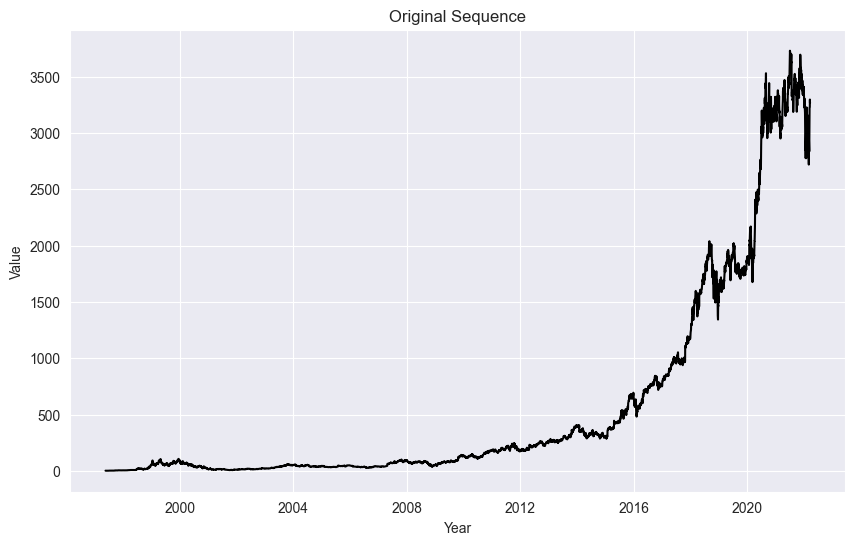

In [45]:
plot_timeseries_sequence(amazon_data["Close"], "Original Sequence", "Year", "Value")

Given the great length of the timeseries, let's focus on some sub-segments, so that we can better appreciate its behavior.

In [28]:
segment_1 = amazon_data[60:260]
segment_2 = amazon_data[960:1160]
segment_3 = amazon_data[3120:3320]
segment_4 = amazon_data[4320:4520]
segment_5 = amazon_data[5640:5840]
segment_6 = amazon_data[6000:6200]

How do the plots and networks (graphs) for these segments look like?

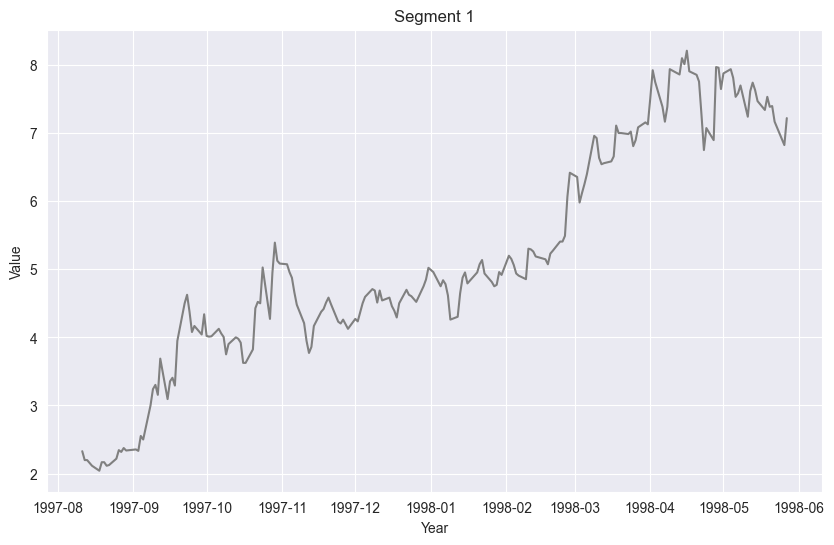

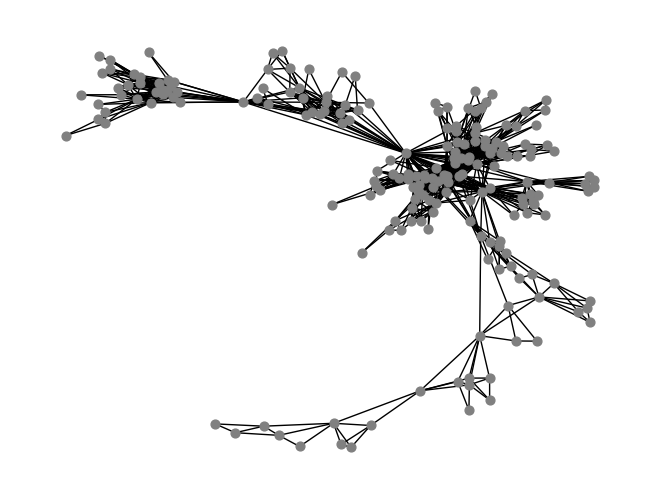

In [47]:
plot_timeseries_sequence(segment_1["Close"], "Segment 1", "Year", "Value", 'gray')
sequence_to_graph(segment_1["Close"], 'gray')

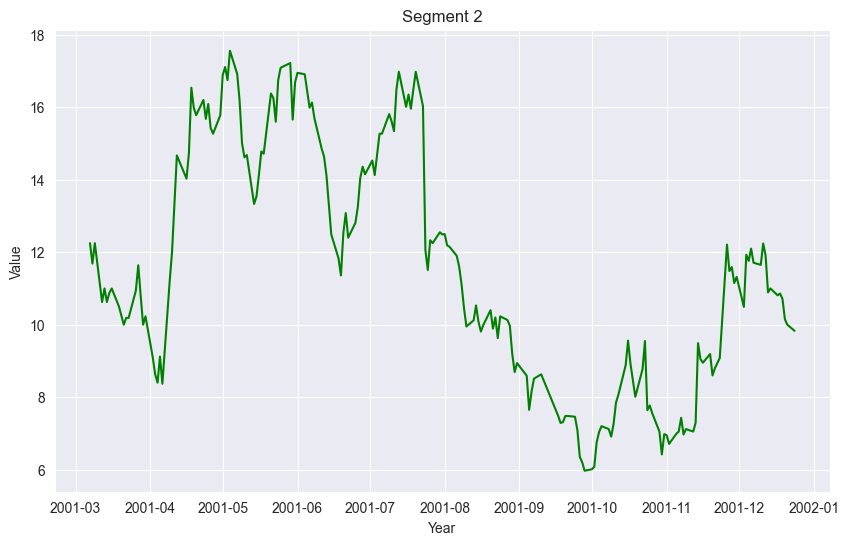

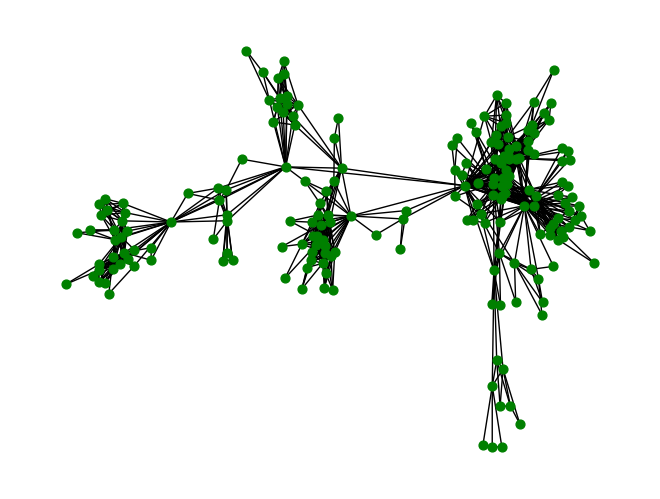

In [50]:
plot_timeseries_sequence(segment_2["Close"], "Segment 2", "Year", "Value", 'green')
sequence_to_graph(segment_2["Close"], 'green')

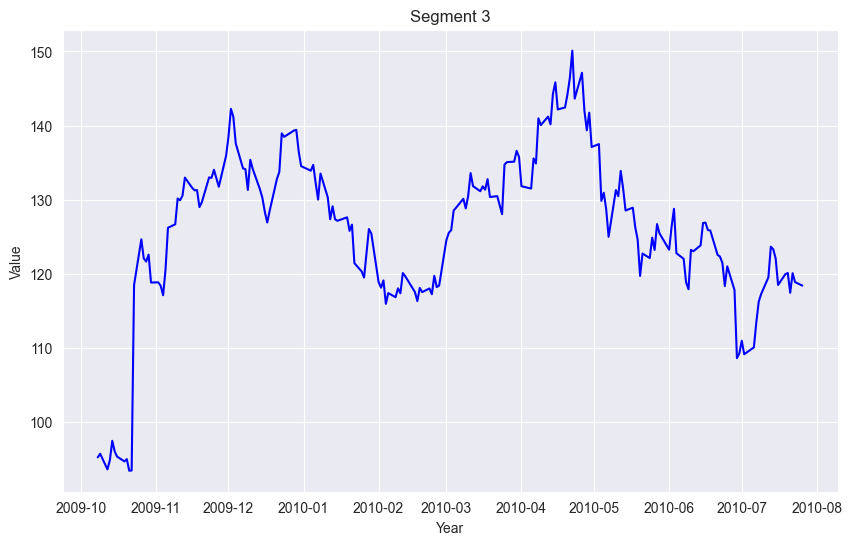

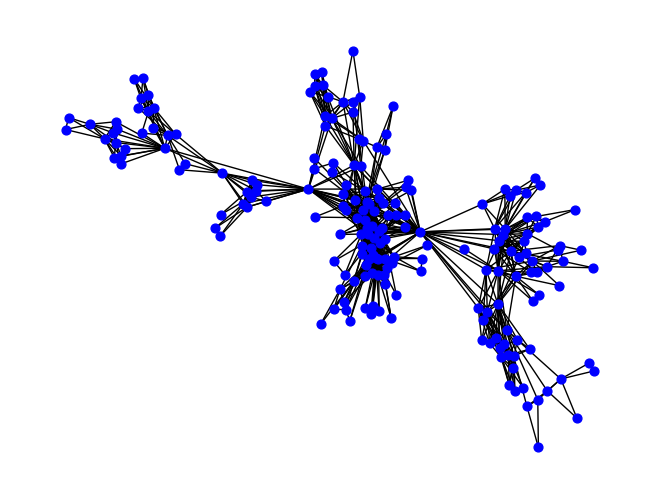

In [51]:
plot_timeseries_sequence(segment_3["Close"], "Segment 3", "Year", "Value", 'blue')
sequence_to_graph(segment_3["Close"], 'blue')

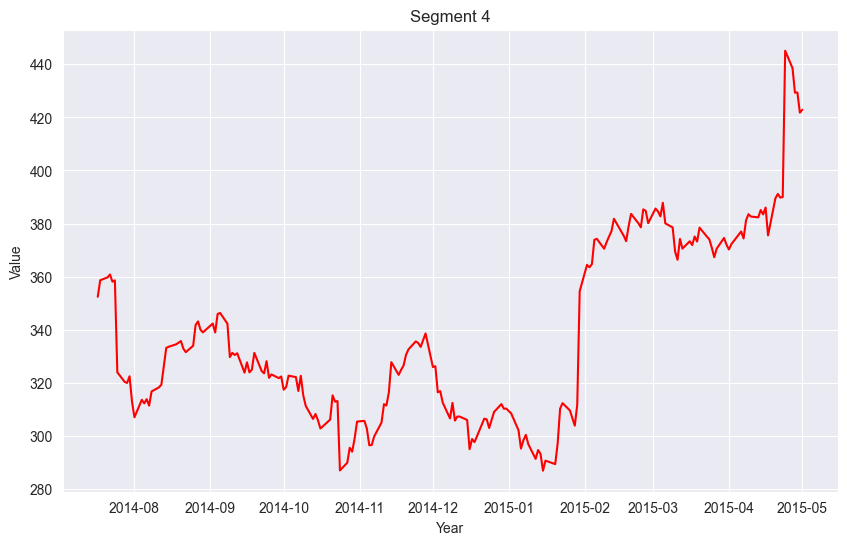

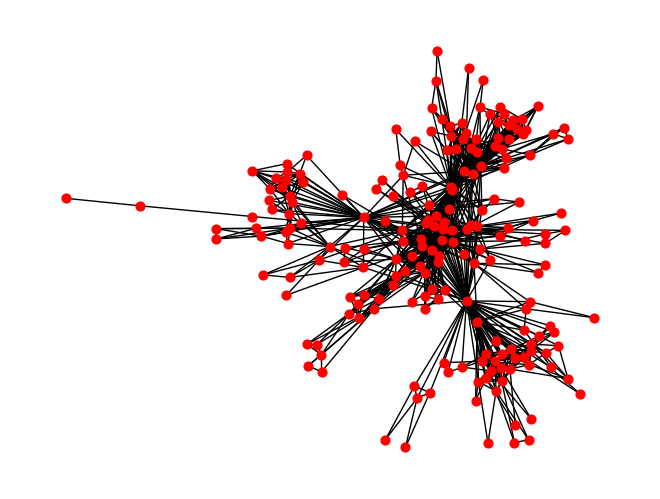

In [52]:
plot_timeseries_sequence(segment_4["Close"], "Segment 4", "Year", "Value", 'red')
sequence_to_graph(segment_4["Close"], 'red')

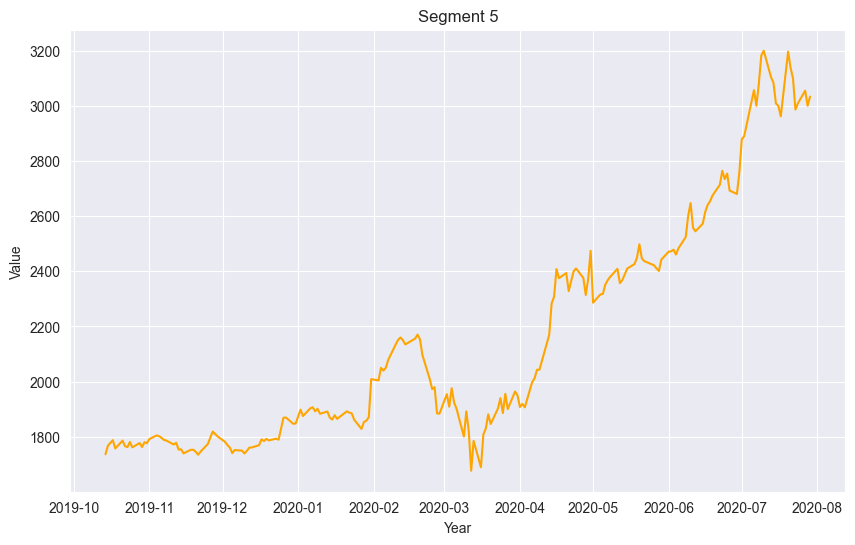

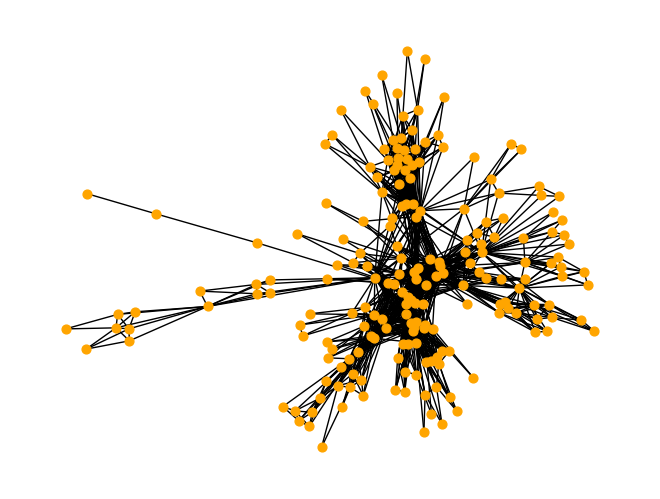

In [54]:
plot_timeseries_sequence(segment_5["Close"], "Segment 5", "Year", "Value", 'orange')
sequence_to_graph(segment_5["Close"], 'orange')

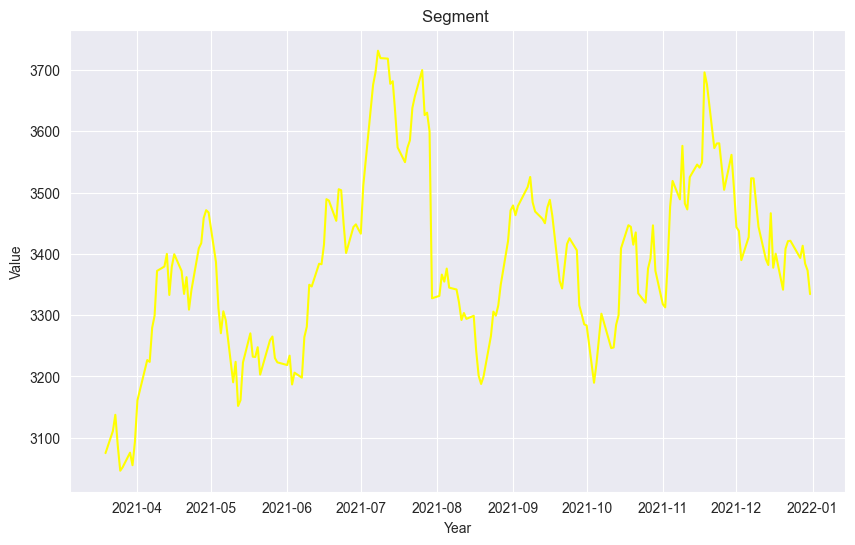

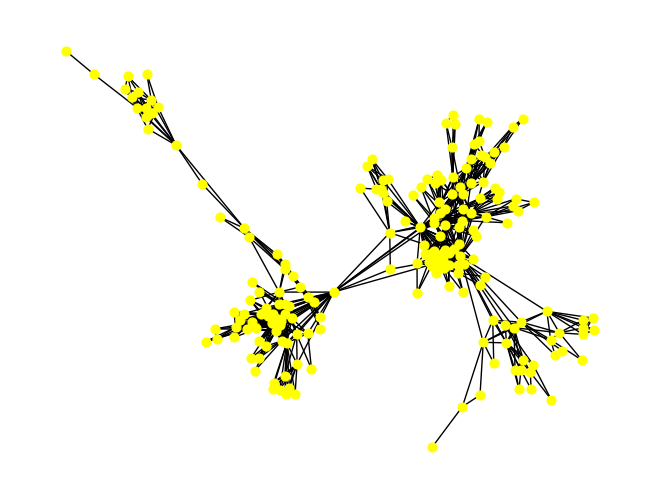

In [55]:
plot_timeseries_sequence(segment_6["Close"], "Segment ", "Year", "Value", 'yellow')
sequence_to_graph(segment_6["Close"], 'yellow')

Let's turn the timeseries into vectors!

In [60]:
def normalize_data(dataset,column):
    data = dataset[column].values
    scaler = MinMaxScaler()
    return scaler.fit_transform(data.reshape(-1, 1)).flatten()    

This function normalizes a specific column of a dataset using the Min-Max scaling technique. Normalization is a common preprocessing step in machine learning, ensuring that all features have the same scale. It helps algorithms converge faster and perform better.

In [61]:
def create_and_train_ts_embedding (data, window_size=100, epochs=20):
    ts_embedding = TimeSeriesEmbedding(data, window_size)
    print(ts_embedding)
    print(ts_embedding.data.size)
    ts_embedding.train_lstm(epochs)
    print(ts_embedding)
    return ts_embedding

Here, a method called TimeSeriesEmbedding is employed to generate embeddings for time series data. Embeddings serve as compact representations of data in a lower-dimensional space, effectively capturing significant patterns and relationships. The function utilizes a window-based strategy to derive embeddings from the time series data. Furthermore, it includes the training of a Long Short-Term Memory (LSTM) neural network model. This model is trained to discern intricate embeddings directly from the data, enhancing comprehension of temporal dynamics and facilitating subsequent analyses.

In [62]:
def print_ts_embeddings_info(ts_embedding):
    embeddings = ts_embedding.get_embeddings()
    print("Shape of embeddings:", embeddings.shape)
    print("Sample embeddings:\n", embeddings[:5])
    return embeddings

This function retrieves and presents information regarding the embeddings produced by the TimeSeriesEmbedding model. It offers insights into the shape of the embeddings and presents a glimpse of the embeddings themselves, facilitating further analysis and interpretation.

In [63]:
def calculate_embeddings_similarity(ts_embedding, similarity_threshold=0.9):
    embeddings = ts_embedding.get_embeddings()
    num_embeddings = embeddings.shape[0]
    similarity_matrix = np.zeros((num_embeddings, num_embeddings))
    similar_pairs = []
    
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):  # Avoid duplicate calculations
            cosine_dist = cosine(embeddings[i], embeddings[j])
            similarity_matrix[i, j] = cosine_dist
            similarity_matrix[j, i] = cosine_dist
            
            # Calculate cosine similarity (1 - cosine distance)
            cosine_sim = 1 - cosine_dist
            if cosine_sim > similarity_threshold:
                similar_pairs.append((i, j, cosine_sim))
    
    print("Pairwise cosine distances:\n", similarity_matrix)
    print("Similar pairs (above threshold):\n", similar_pairs)
    return similarity_matrix, similar_pairs

We can calculates the similarity between embeddings generated from time series data with the funcion above. It computes the cosine distance between each pair of embeddings and identifies pairs with similarity exceeding a specified threshold. The calculated pairwise cosine distances are stored in a matrix, while pairs exceeding the threshold are recorded along with their cosine similarity values. This analysis aids in identifying patterns and relationships within the time series data, facilitating further insights and analysis.

In [70]:
def plot_similarity_heatmap(similarity_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='coolwarm')
    plt.title("Heatmap of Pairwise Cosine Distances")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Index")
    plt.show()

The provided similarity matrix is plotted using a color map ('coolwarm') to represent the cosine distances. The resulting heatmap provides a visual representation of similarity relationships between embeddings, with warmer colors indicating higher similarity and cooler colors indicating lower similarity. This visualization aids in understanding the clustering and relationships within the embeddings, facilitating further analysis and interpretation.

In [71]:
data_1 = normalize_data(segment_1,'Close')
ts_embedding_1 = create_and_train_ts_embedding (data_1)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5211Epoch 1, Loss: 0.47324061393737793
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.5019
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2536Epoch 2, Loss: 0.22801032662391663
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2434
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0743Epoch 3, Loss: 0.058203402906656265
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0711
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0079Epoch 4, Loss: 0.014114398509263992
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0104
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0371Epoch 5, Loss: 0.03215336054563522
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0351
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0063Epoch 6, Loss: 0.005707599688321352
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0062
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0062Epoch 7, Loss: 0.006916380487382412
4/4

In [72]:
embeddings_1 = print_ts_embeddings_info (ts_embedding_1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.00526475  0.04446673  0.0318211  -0.06522641 -0.06024121  0.07265902
   0.04961284  0.06597164 -0.05768169 -0.09233582 -0.06531265 -0.0810609
  -0.05031352 -0.04254109  0.03175095 -0.01318643 -0.02182971  0.09067791
  -0.0896455   0.08553208  0.04139069 -0.00699654 -0.0314168  -0.07030439
  -0.03551989 -0.01349229 -0.00197451  0.01450286 -0.12916382 -0.04232987
   0.00462351 -0.0278608   0.02037337 -0.09409526  0.01579384 -0.00312442
  -0.11132725 -0.11157361  0.02568994  0.00468017 -0.00643589 -0.11287718
  -0.0613848  -0.10477451 -0.00549543 -0.02547382  0.03402268 -0.13036041
  -0.03323613  0.04014017]
 [-0.00462723  0.04448925  0.03268223 -0.06688702 -0.06108766  0.07386196
   0.04959012  0.06727996 -0.05928563 -0.09381169 -0.06630854 -0.08215663
  -0.05042949 -0.04355882  0.03269854 -0.01358192 -0.02174007  0.09225184
  -0.09133045  0.08671416  0.0419248  -0.00735983 -0.03104202 -0.07164

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Pairwise cosine distances:
 [[0.00000000e+00 2.39904187e-05 4.71287427e-05 ... 3.62466875e-03
  3.37498969e-03 3.01347707e-03]
 [2.39904187e-05 0.00000000e+00 4.76988938e-05 ... 3.23578150e-03
  3.02030028e-03 2.72954416e-03]
 [4.71287427e-05 4.76988938e-05 0.00000000e+00 ... 3.33967773e-03
  3.07331513e-03 2.67774504e-03]
 ...
 [3.62466875e-03 3.23578150e-03 3.33967773e-03 ... 0.00000000e+00
  2.04241098e-05 1.85799806e-04]
 [3.37498969e-03 3.02030028e-03 3.07331513e-03 ... 2.04241098e-05
  0.00000000e+00 8.34003239e-05]
 [3.01347707e-03 2.72954416e-03 2.67774504e-03 ... 1.85799806e-04
  8.34003239e-05 0.00000000e+00]]
Similar pairs (above threshold):
 [(0, 1, 0.9999760095812732), (0, 2, 0.9999528712573389), (0, 3, 0.9999246122622564), (0, 4, 0.9998622416932822), (0, 5, 0.9996234510257549), (0, 6, 0.9985668469155105), (0, 7, 0.9976044013201536), (0, 8, 0.998165629846127), (0, 9, 0.9991086725759314), (0, 10, 0.999662288217445), (0, 11, 0.9997365502

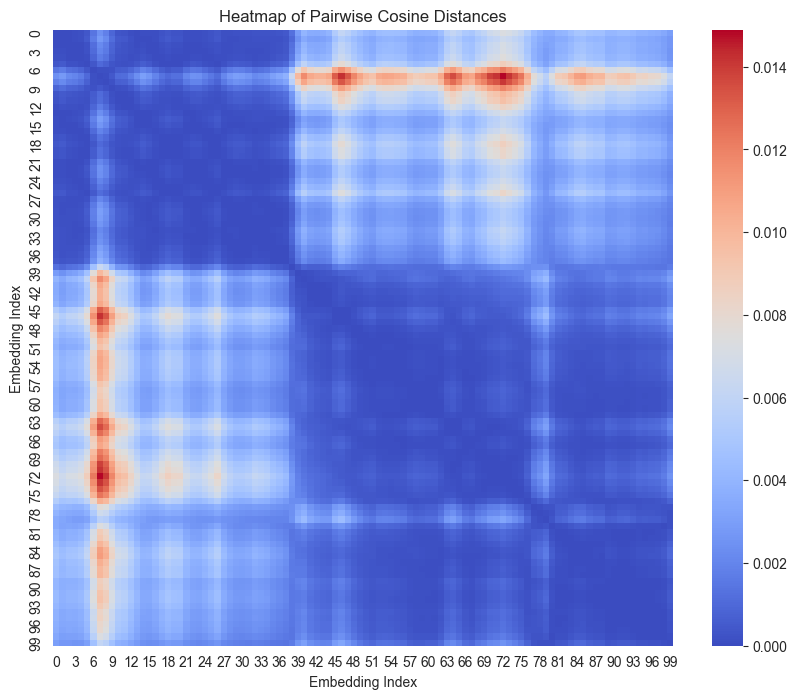

In [73]:
similarity_matrix_1, similar_pairs_1 = calculate_embeddings_similarity(ts_embedding_1)
plot_similarity_heatmap(similarity_matrix_1)

In [74]:
data_2 = normalize_data(segment_2,'Close')
ts_embedding_2 = create_and_train_ts_embedding (data_2)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0786Epoch 1, Loss: 0.07649895548820496
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0777
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0451Epoch 2, Loss: 0.0336703322827816
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0406
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0102Epoch 3, Loss: 0.01122931856662035
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0106
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0136Epoch 4, Loss: 0.01354636438190937
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0136
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0105Epoch 5, Loss: 0.009744862094521523
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0102
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0079Epoch 6, Loss: 0.008583278395235538
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0082
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0106Epoch 7, Loss: 0.008735224604606628
4/4 ━

In [75]:
embeddings_2 = print_ts_embeddings_info (ts_embedding_2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-5.02940938e-02 -1.24439508e-01 -3.52285244e-02  2.38370523e-02
   3.98253230e-03  1.27052441e-02 -3.37251984e-02  8.23446736e-02
  -4.87042917e-03 -1.09456271e-01  1.06042750e-01  6.60296232e-02
  -4.31479886e-02 -2.23578606e-02  2.19789497e-03 -1.33690342e-01
   6.73453137e-02 -2.29378492e-02 -4.15778067e-03 -9.93758962e-02
   5.42541146e-02 -2.28916481e-01 -3.47696505e-02 -1.35366976e-01
  -1.55209348e-01  1.92576781e-01  9.38966032e-03  1.50301140e-02
   1.31771058e-01 -5.88064687e-03 -7.09493533e-02 -8.17811340e-02
   4.55157012e-02 -3.20104569e-01 -1.60301611e-01 -1.11292049e-01
   8.52811933e-02  4.23794193e-03 -2.98329204e-01 -1.34724844e-02
   9.51777697e-02  1.87941208e-01 -1.06015906e-01  1.01116188e-01
   1.12671452e-02 -4.11518924e-02 -7.71056265e-02 -2.93440334e-02
  -7.50159994e-02 -1.04074972e-02]
 [-4.64158729e-02 -1.19675890e-01 -3.12909484e-02  2.41621044e-02
   3.63082089e-03 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Pairwise cosine distances:
 [[0.         0.00026335 0.00088256 ... 0.00622557 0.00419321 0.00293884]
 [0.00026335 0.         0.00018836 ... 0.00781558 0.00543871 0.00381497]
 [0.00088256 0.00018836 0.         ... 0.00921555 0.00663459 0.00477047]
 ...
 [0.00622557 0.00781558 0.00921555 ... 0.         0.00032775 0.00117809]
 [0.00419321 0.00543871 0.00663459 ... 0.00032775 0.         0.0002665 ]
 [0.00293884 0.00381497 0.00477047 ... 0.00117809 0.0002665  0.        ]]
Similar pairs (above threshold):
 [(0, 1, 0.9997366474319915), (0, 2, 0.9991174397517595), (0, 3, 0.9983458828442121), (0, 4, 0.9975921650352146), (0, 5, 0.9968859862110863), (0, 6, 0.9963263375421327), (0, 7, 0.9959254334462396), (0, 8, 0.9956597503853715), (0, 9, 0.9952479712001023), (0, 10, 0.994221793588606), (0, 11, 0.9931161509606031), (0, 12, 0.9925805948729683), (0, 13, 0.9919779636888121), (0, 14, 0.9914068425688631), (0, 15, 0.9911663514277592), (0, 16, 0.9911599153920966), (

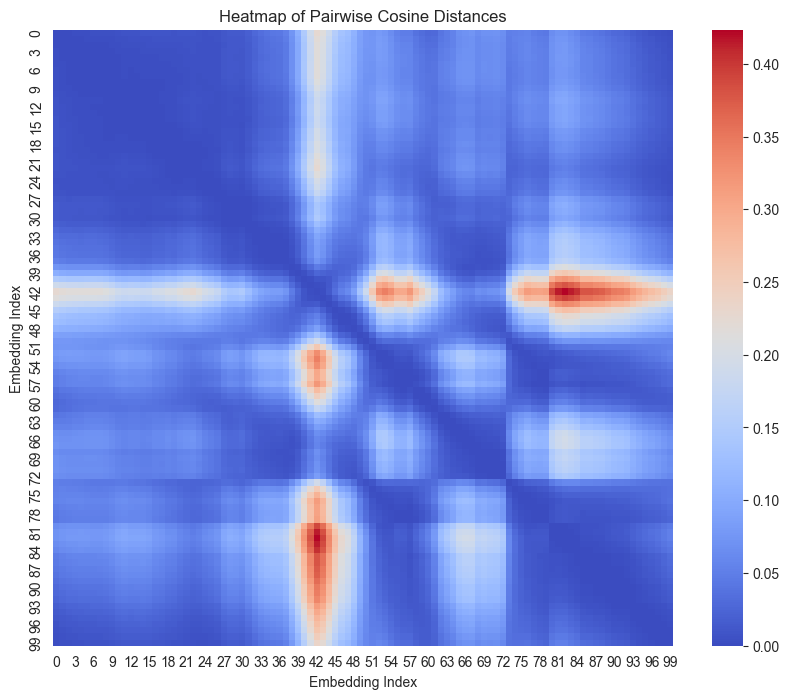

In [76]:
similarity_matrix_2, similar_pairs_2 = calculate_embeddings_similarity(ts_embedding_2)
plot_similarity_heatmap(similarity_matrix_2)

In [79]:
data_3 = normalize_data(segment_3,'Close')
ts_embedding_3 = create_and_train_ts_embedding (data_3)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3250Epoch 1, Loss: 0.2881503999233246
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.3102
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1451Epoch 2, Loss: 0.1255767047405243
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1412
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0250Epoch 3, Loss: 0.0180552639067173
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0222
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0445Epoch 4, Loss: 0.05031919479370117
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0468
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0190Epoch 5, Loss: 0.01718108355998993
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0186
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0085Epoch 6, Loss: 0.009555522352457047
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0089
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0148Epoch 7, Loss: 0.014880150556564331
4/4 ━━━━

In [80]:
embeddings_3 = print_ts_embeddings_info (ts_embedding_3)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E9E4098D60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.06052814  0.02153995 -0.01912694  0.05950114  0.09620158 -0.06070793
   0.07469687 -0.02121197 -0.131042   -0.00539507  0.00153286  0.0715377

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Pairwise cosine distances:
 [[0.00000000e+00 1.16577839e-04 3.08541365e-04 ... 7.18637395e-04
  6.55963358e-04 8.14086626e-04]
 [1.16577839e-04 0.00000000e+00 4.83157364e-05 ... 1.34267364e-03
  1.25809850e-03 1.47741102e-03]
 [3.08541365e-04 4.83157364e-05 0.00000000e+00 ... 1.80735567e-03
  1.71235015e-03 1.96385939e-03]
 ...
 [7.18637395e-04 1.34267364e-03 1.80735567e-03 ... 0.00000000e+00
  4.86494698e-06 1.08907030e-05]
 [6.55963358e-04 1.25809850e-03 1.71235015e-03 ... 4.86494698e-06
  0.00000000e+00 1.07030820e-05]
 [8.14086626e-04 1.47741102e-03 1.96385939e-03 ... 1.08907030e-05
  1.07030820e-05 0.00000000e+00]]
Similar pairs (above threshold):
 [(0, 1, 0.9998834221606262), (0, 2, 0.9996914586347526), (0, 3, 0.9994560781154328), (0, 4, 0.9994138314917406), (0, 5, 0.9992815873627643), (0, 6, 0.9989622765538553), (0, 7, 0.998924717459942), (0, 8, 0.9989687286711298), (0, 9, 0.998963387323233), (0, 10, 0.9989854214612309), (0, 11, 0.9989362110

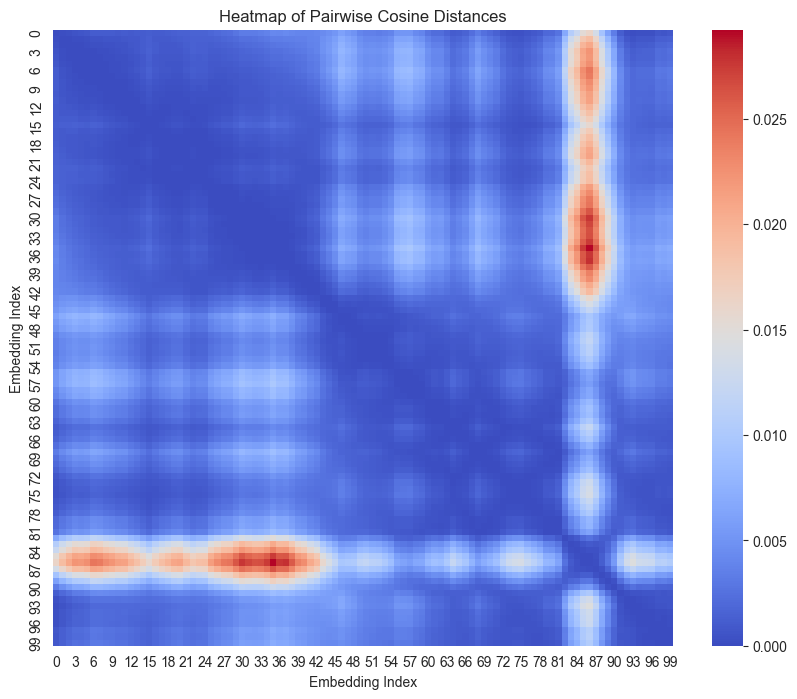

In [81]:
similarity_matrix_3, similar_pairs_3 = calculate_embeddings_similarity(ts_embedding_3)
plot_similarity_heatmap(similarity_matrix_3)

In [82]:
data_4 = normalize_data(segment_4,'Close')
ts_embedding_4 = create_and_train_ts_embedding (data_4)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2713Epoch 1, Loss: 0.24378833174705505
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.2603
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1646Epoch 2, Loss: 0.14430302381515503
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1565
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0630Epoch 3, Loss: 0.06142139434814453
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0623
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0210Epoch 4, Loss: 0.021309982985258102
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0211
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0347Epoch 5, Loss: 0.036999620497226715
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0356
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0243Epoch 6, Loss: 0.019217416644096375
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0223
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0164Epoch 7, Loss: 0.017874479293823242
4/4

In [83]:
embeddings_4 = print_ts_embeddings_info (ts_embedding_4)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.00401786 -0.01243488  0.00933117 -0.00227623 -0.01951679  0.0038288
  -0.03524797 -0.01714925 -0.03517023 -0.01477641 -0.05598015 -0.01849806
   0.02848613 -0.02731501 -0.01904139  0.04949055  0.01485305  0.03123289
  -0.07316715  0.01831342  0.02819611  0.00385381 -0.0443219  -0.04486534
   0.02024115 -0.04854734  0.05226996 -0.03254223  0.03987236  0.09105824
  -0.04060679 -0.02407633 -0.00025466 -0.05518118  0.0059605  -0.03617199
   0.0309817  -0.10141698 -0.04585914 -0.05945183  0.00958055  0.04506734
  -0.02804251  0.04921337  0.08451988  0.01043138  0.04254453 -0.01280482
  -0.00905364  0.01366079]
 [-0.00348538 -0.01572456  0.00772342 -0.00469315 -0.01894957  0.00596139
  -0.03251377 -0.01752095 -0.03810276 -0.01269871 -0.05209536 -0.01692115
   0.0267997  -0.02302139 -0.02036382  0.04673949  0.01849986  0.03211088
  -0.06920156  0.01841611  0.02358501  0.00265908 -0.03971171 -0.045981

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pairwise cosine distances:
 [[0.00000000e+00 1.30751717e-03 2.37327773e-03 ... 4.90028708e-02
  4.88010986e-02 4.62601490e-02]
 [1.30751717e-03 0.00000000e+00 2.27799280e-04 ... 6.46102125e-02
  6.43507848e-02 6.13080661e-02]
 [2.37327773e-03 2.27799280e-04 0.00000000e+00 ... 7.01129691e-02
  6.99485237e-02 6.68691571e-02]
 ...
 [4.90028708e-02 6.46102125e-02 7.01129691e-02 ... 0.00000000e+00
  4.08460158e-05 2.35503022e-04]
 [4.88010986e-02 6.43507848e-02 6.99485237e-02 ... 4.08460158e-05
  0.00000000e+00 9.93887788e-05]
 [4.62601490e-02 6.13080661e-02 6.68691571e-02 ... 2.35503022e-04
  9.93887788e-05 0.00000000e+00]]
Similar pairs (above threshold):
 [(0, 1, 0.9986924828328749), (0, 2, 0.9976267222666525), (0, 3, 0.9942749145489974), (0, 4, 0.9914525443662322), (0, 5, 0.9888744353953574), (0, 6, 0.9858355697470395), (0, 7, 0.972796768726448), (0, 8, 0.963560616745862), (0, 9, 0.9528799913719226), (0, 10, 0.946906204741005), (0, 11, 0.95384642500

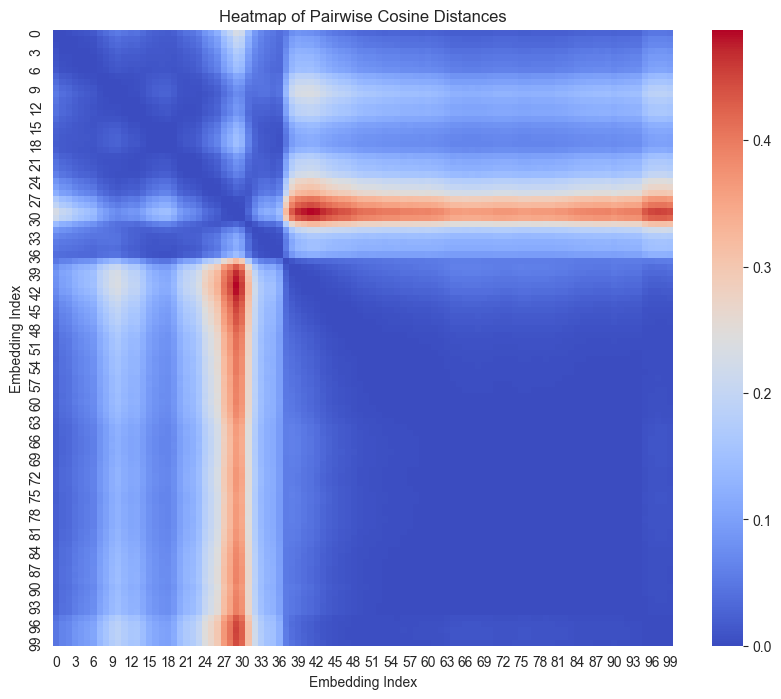

In [85]:
similarity_matrix_4, similar_pairs_4 = calculate_embeddings_similarity(ts_embedding_4)
plot_similarity_heatmap(similarity_matrix_4)

In [86]:
data_5 = normalize_data(segment_5,'Close')
ts_embedding_5 = create_and_train_ts_embedding (data_5)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3327Epoch 1, Loss: 0.2724708020687103
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.3086
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1332 Epoch 2, Loss: 0.11580657213926315
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1262
Epoch 3/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0347Epoch 3, Loss: 0.024481715634465218
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0306
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0242Epoch 4, Loss: 0.02743440680205822
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0248
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0218Epoch 5, Loss: 0.017094256356358528
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0199
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0087Epoch 6, Loss: 0.008891587145626545
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0087
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0117Epoch 7, Loss: 0.012256800197064877
4/4

In [87]:
embeddings_5 = print_ts_embeddings_info (ts_embedding_5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[-0.02246035  0.04322534 -0.02923302 -0.02058825  0.0330499   0.05773512
   0.04341257  0.041837    0.01636934  0.02564109  0.00434045 -0.01727981
  -0.01711419 -0.01710831 -0.01165473  0.01858346  0.0448159   0.02318146
  -0.02992247 -0.00308854 -0.02504417  0.02644502 -0.01634889 -0.02898082
   0.04417063  0.01012937 -0.00963095  0.01873156  0.01393618  0.03499002
   0.03885689 -0.02294807 -0.01294527  0.04441616  0.01344253 -0.00662827
  -0.00535968  0.00883135 -0.03540457  0.03426186  0.02494431 -0.01197769
  -0.03074989  0.00465658 -0.03010207  0.01011923 -0.01275744 -0.02679997
   0.02011162 -0.00798569]
 [-0.01875527  0.03977555 -0.02861425 -0.02083709  0.03170121  0.05338841
   0.04172748  0.03742529  0.01535275  0.0231804   0.00480696 -0.01919857
  -0.01820109 -0.01695282 -0.01150681  0.01660468  0.04251551  0.02078027
  -0.02937496 -0.00303908 -0.02444714  0.02442041 -0.01406952 -0.0275

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pairwise cosine distances:
 [[0.00000000e+00 2.44108738e-03 3.11681560e-03 ... 1.00040093e-01
  9.93586280e-02 9.72816671e-02]
 [2.44108738e-03 0.00000000e+00 2.69871270e-04 ... 1.30451911e-01
  1.29686403e-01 1.27268195e-01]
 [3.11681560e-03 2.69871270e-04 0.00000000e+00 ... 1.36719342e-01
  1.35917368e-01 1.33491473e-01]
 ...
 [1.00040093e-01 1.30451911e-01 1.36719342e-01 ... 0.00000000e+00
  5.08590579e-06 3.38499329e-05]
 [9.93586280e-02 1.29686403e-01 1.35917368e-01 ... 5.08590579e-06
  0.00000000e+00 1.91324745e-05]
 [9.72816671e-02 1.27268195e-01 1.33491473e-01 ... 3.38499329e-05
  1.91324745e-05 0.00000000e+00]]
Similar pairs (above threshold):
 [(0, 1, 0.9975589126201437), (0, 2, 0.996883184404969), (0, 3, 0.9920506650563644), (0, 4, 0.9672897839437945), (0, 5, 0.9545394036703387), (0, 6, 0.9158921132220627), (0, 7, 0.9100888266526147), (0, 8, 0.910953094487273), (0, 9, 0.9254129198401482), (0, 10, 0.9294351353207001), (0, 11, 0.9438071640

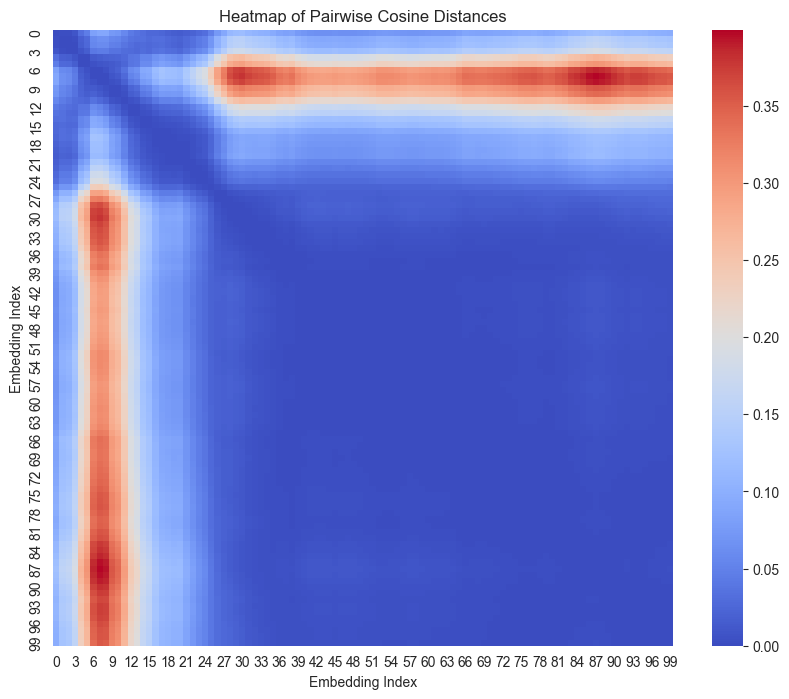

In [88]:
similarity_matrix_5, similar_pairs_5 = calculate_embeddings_similarity(ts_embedding_5)
plot_similarity_heatmap(similarity_matrix_5)

In [89]:
data_6 = normalize_data(segment_6,'Close')
ts_embedding_6 = create_and_train_ts_embedding (data_6)

200
Epoch 1/20


C:\Users\Gjorgji\PycharmProjects\ts2g2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.2330Epoch 1, Loss: 0.2042331099510193
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.2215
Epoch 2/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0970Epoch 2, Loss: 0.08032771199941635
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0903
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0180Epoch 3, Loss: 0.01787744089961052
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0180
Epoch 4/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0366Epoch 4, Loss: 0.03798229992389679
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0371
Epoch 5/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0206Epoch 5, Loss: 0.018674444407224655
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0198
Epoch 6/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0128Epoch 6, Loss: 0.012452797964215279
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0127
Epoch 7/20
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0122Epoch 7, Loss: 0.01352264080196619
4/4 ━━

In [90]:
embeddings_6 = print_ts_embeddings_info (ts_embedding_6)
print(embeddings_6.size)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Shape of embeddings: (100, 50)
Sample embeddings:
 [[ 0.00277956  0.0233896   0.07279738 -0.05751402  0.07473962 -0.13804406
   0.10308606 -0.07549828  0.05569788 -0.16098954 -0.11482809 -0.17577346
   0.06560615 -0.1570554   0.00025726  0.00804257  0.0984105  -0.03242042
  -0.06932975  0.0403656  -0.05693656  0.03254097  0.06400172  0.03336628
  -0.04458192 -0.16676432  0.07022799 -0.06449296 -0.01379444  0.11051811
   0.03821442 -0.03432425  0.02588688  0.00576811 -0.07256407  0.04412498
  -0.0270023   0.02954222 -0.04638083 -0.04878452 -0.01145037 -0.09576017
  -0.07962192  0.05421357  0.01086431 -0.07133537  0.02442866  0.00842004
  -0.10605519  0.1430135 ]
 [ 0.00410627  0.02261567  0.07076005 -0.05445024  0.07173768 -0.13200578
   0.09864272 -0.07348209  0.0548479  -0.15291588 -0.10850229 -0.16723727
   0.06372188 -0.15000053  0.00028845  0.00719857  0.09465049 -0.02957475
  -0.06618166  0.03874505 -0.05545338  0.03321489  0.06122604  0.03402

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Pairwise cosine distances:
 [[0.00000000e+00 1.12100359e-04 2.34255350e-04 ... 7.20824777e-03
  6.78361206e-03 6.19593200e-03]
 [1.12100359e-04 0.00000000e+00 4.48870072e-05 ... 8.67251593e-03
  8.19366207e-03 7.53113806e-03]
 [2.34255350e-04 4.48870072e-05 0.00000000e+00 ... 8.75579873e-03
  8.29185844e-03 7.63788323e-03]
 ...
 [7.20824777e-03 8.67251593e-03 8.75579873e-03 ... 0.00000000e+00
  2.15652671e-05 9.03713235e-05]
 [6.78361206e-03 8.19366207e-03 8.29185844e-03 ... 2.15652671e-05
  0.00000000e+00 2.50755294e-05]
 [6.19593200e-03 7.53113806e-03 7.63788323e-03 ... 9.03713235e-05
  2.50755294e-05 0.00000000e+00]]
Similar pairs (above threshold):
 [(0, 1, 0.9998878996414279), (0, 2, 0.9997657446498647), (0, 3, 0.9995836930251192), (0, 4, 0.9994148552837651), (0, 5, 0.9988992494586374), (0, 6, 0.9973374533759655), (0, 7, 0.9950309451279167), (0, 8, 0.9936199879986475), (0, 9, 0.9956436431446078), (0, 10, 0.9968155537564392), (0, 11, 0.99635818

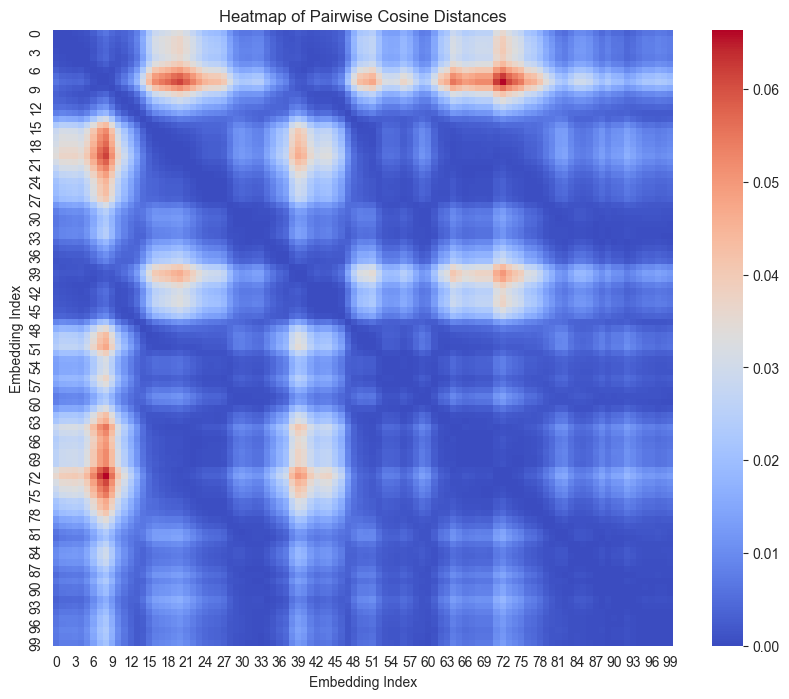

In [91]:
similarity_matrix_6, similar_pairs_6 = calculate_embeddings_similarity(ts_embedding_6)
plot_similarity_heatmap(similarity_matrix_6)